Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!unzip -o "/content/drive/MyDrive/Colab Notebooks/ML/Assessment/Melanoma Detection Assignment/CNN_assignment.zip" -d '/content/drive/MyDrive/Colab Notebooks/ML/Assessment/Melanoma Detection Assignment'
!unzip -o "/content/drive/MyDrive/Colab Notebooks/ML/Assessment/Melanoma Detection Assignment/CNN_assignment.zip" > /dev/null


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)
print (image_count_test+image_count_train)

2239
118
2357


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,#label_mode='categorical',
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               validation_split=0.2,subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,#label_mode='categorical',
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               validation_split=0.2,subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

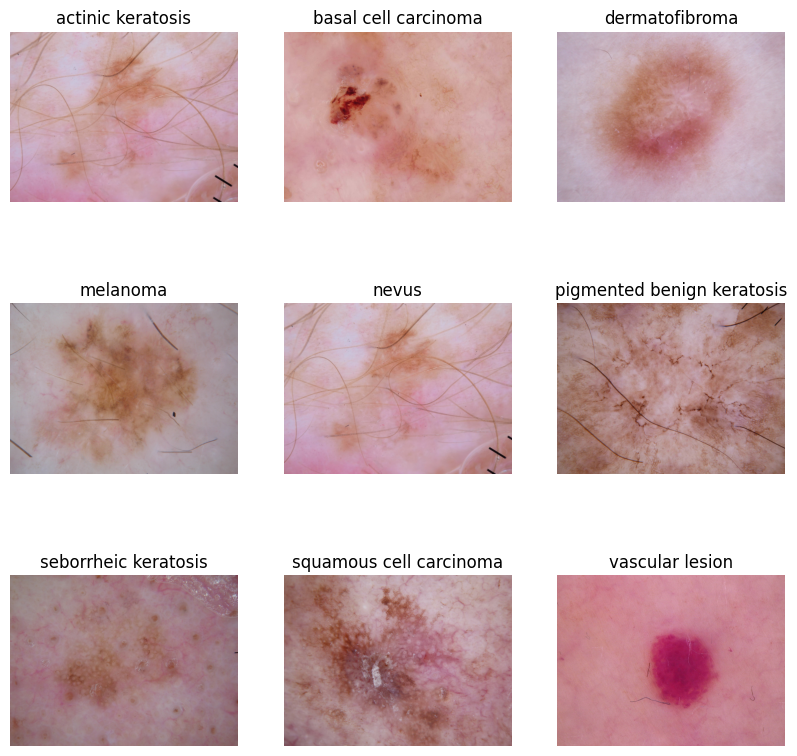

In [12]:
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))

for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  img_path=plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]   )    )
  plt.title(class_names[i])
  plt.imshow(img_path)
  plt.axis('off')


In [13]:
def sub_directories_count(dir):
  count=[]

  for path in pathlib.Path(dir).iterdir():
      if path.is_dir():
        count.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))]))

  sub_directories=[name for name in os.listdir(dir) if os.path.isdir(os.path.join(dir,name))]

  return pd.DataFrame(list(zip(sub_directories,count)),columns=['Sub_dir_name','No. of Images']).sort_values(by='No. of Images')

table1=sub_directories_count(data_dir_train)
table1

,Sub_dir_name,No. of Images
4,seborrheic keratosis,77
8,dermatofibroma,95
5,actinic keratosis,114
6,vascular lesion,139
2,squamous cell carcinoma,181
1,nevus,357
3,basal cell carcinoma,376
0,melanoma,438
7,pigmented benign keratosis,462


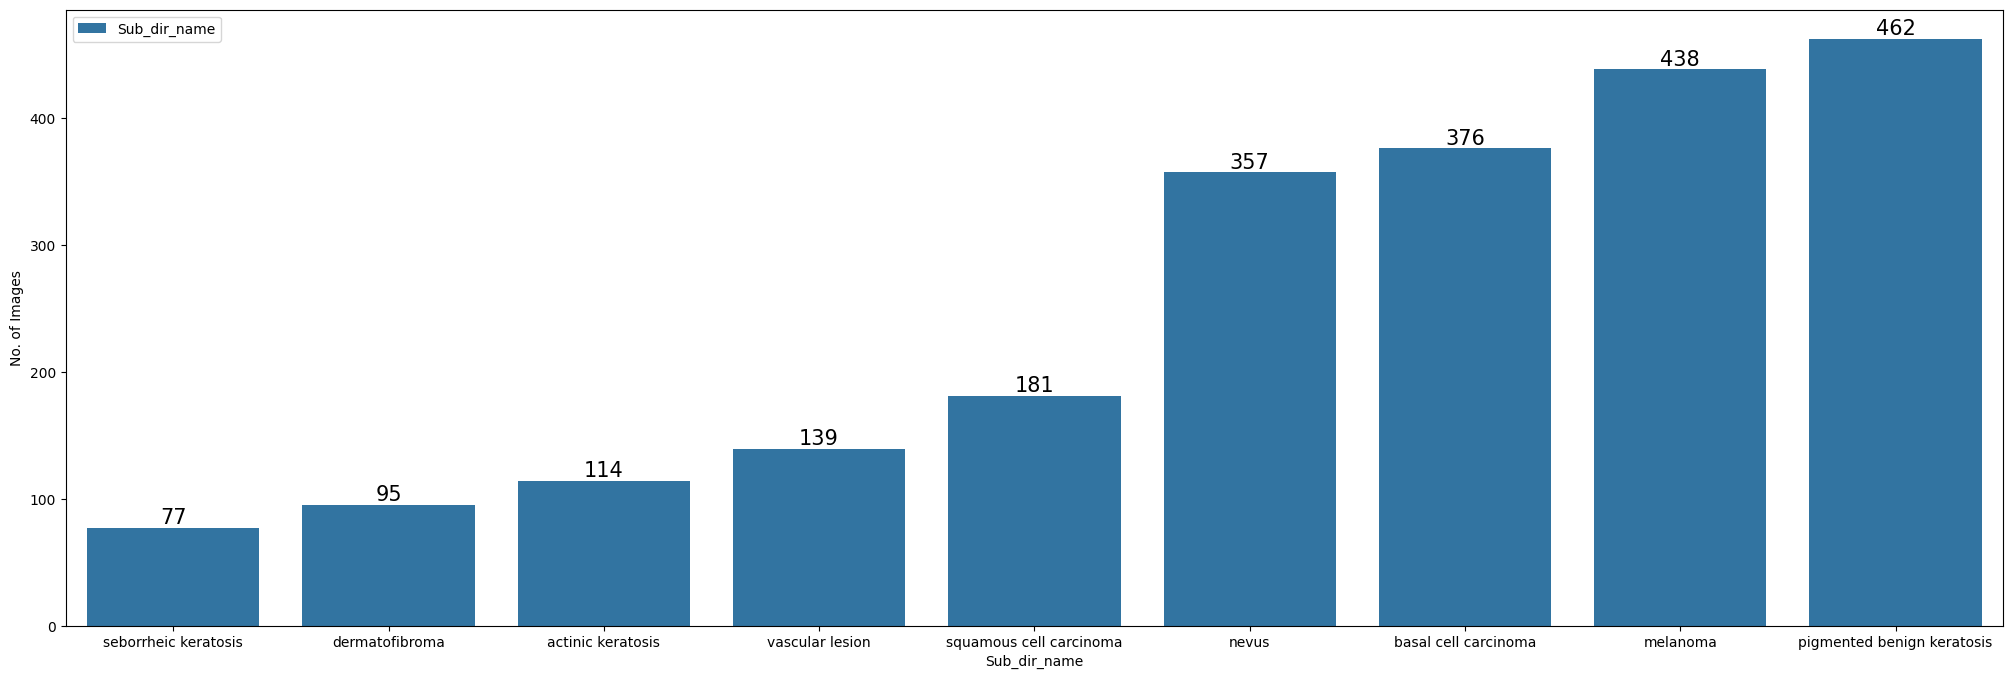

In [14]:
plt.figure(figsize=(25,8))
ax=sns.barplot(data=table1,y='No. of Images',x='Sub_dir_name',label='Sub_dir_name',)
ax.bar_label(ax.containers[0],fontsize=15);

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization
#from tensorflow.keras.layers.experimental.preprocessing import Rescaling

num_classes=9

model=Sequential()

# Rescalling
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

#1st Layer
model.add(layers.Conv2D(32, (3,3), padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#2nd Layer
model.add(layers.Conv2D(64, (3,3), padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd Layer
model.add(layers.Conv2D(128, (3,3), padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#Flattren
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))

#FC Layer
model.add(layers.Dense(num_classes,activation='softmax'))
#model.summary()


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 24s 107ms/step - loss: 1.9559 - accuracy: 0.2902 - val_loss: 1.7409 - val_accuracy: 0.3512
Epoch 2/20
56/56 [==============================] - 3s 53ms/step - loss: 1.6308 - accuracy: 0.4347 - val_loss: 1.5152 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5197 - accuracy: 0.4788 - val_loss: 1.4387 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3542 - accuracy: 0.5312 - val_loss: 1.3569 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 1.2678 - accuracy: 0.5407 - val_loss: 1.3250 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.2297 - accuracy: 0.5647 - val_loss: 1.4045 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1.1822 - accuracy: 0.5798 - val_loss: 1.3864 - val_accuracy: 0.5280
Epoch 8/20
56/56 [====

### Visualizing training results

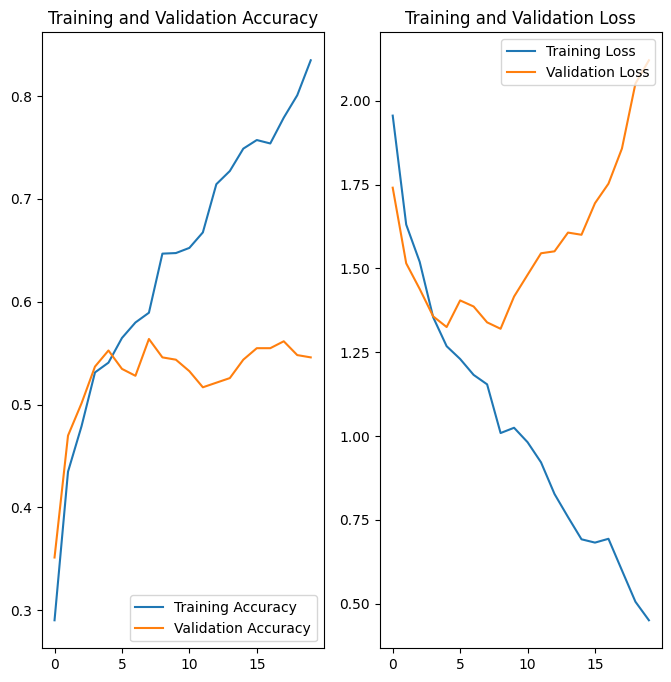

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

 **Finding**


*   The model is showing sign of overfitting, as there is noticeable diffreance in loss & accuracy between training & validation data set, especially around 8th epoche onwards.
*   it's too earli to say that without checking the data distribution oe if any data imbalance to be take care



### Write your findings here

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augument=keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical',input_shape=(img_height,img_width,3)),
                                layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='reflect'),
                                layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3),fill_mode='reflect'),
                                layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode='reflect',interpolation="bilinear",seed=None,fill_value=0.0),
                                layers.experimental.preprocessing.RandomCrop(img_height,img_width),
                                ])


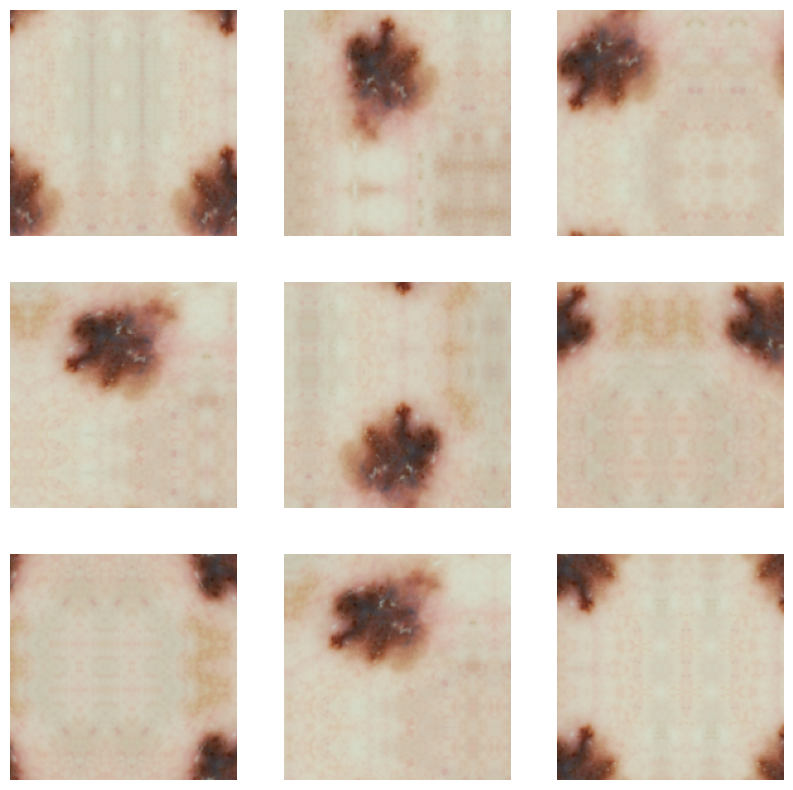

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augument(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

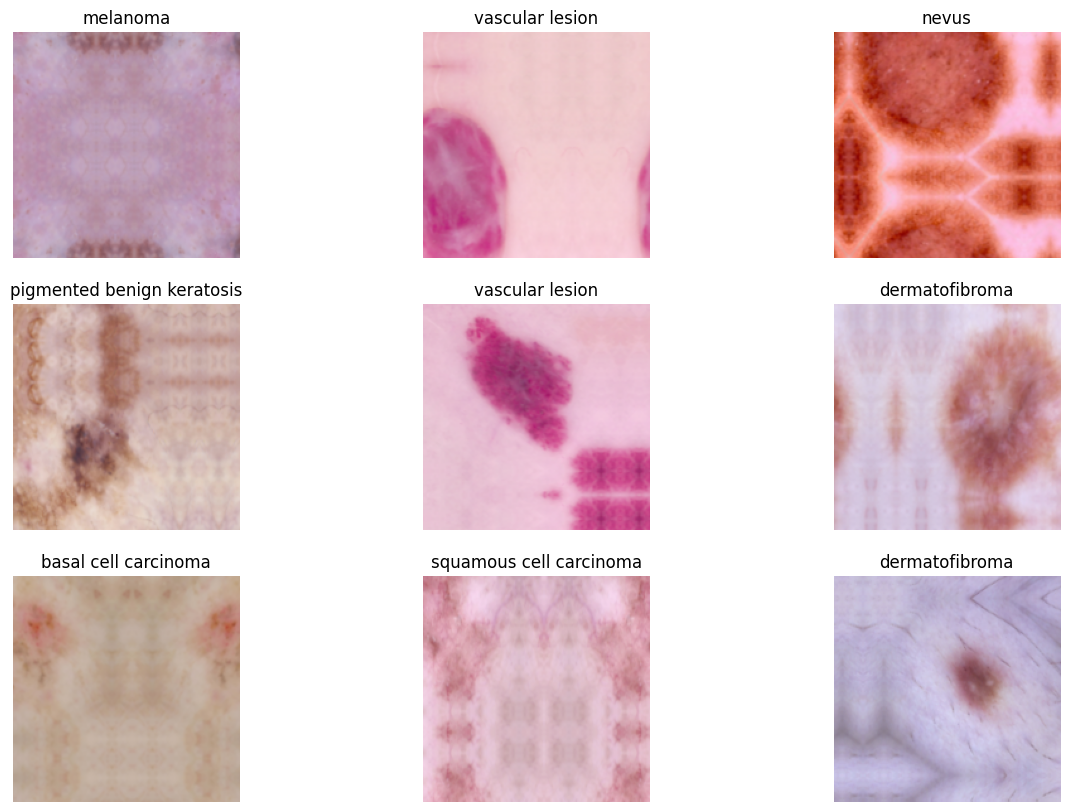

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(15,10))

for images,labels in train_ds.take(1):

  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(data_augument(images)[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')


### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes=9

model=Sequential([data_augument,layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3))])

# Rescalling
#model.add([data_augument,layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3))])

#1st Layer
model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#2nd Layer
model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd Layer
model.add(Conv2D(128, (3,3), padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

#Flattren
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

#FC Layer
model.add(Dense(num_classes,activation='softmax'))
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Compiling the model

In [25]:
## Your code goes here
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 68ms/step - loss: 2.0045 - accuracy: 0.2517 - val_loss: 1.8577 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 1.7856 - accuracy: 0.3376 - val_loss: 1.6731 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 1.7571 - accuracy: 0.3560 - val_loss: 1.6499 - val_accuracy: 0.3669
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 1.7015 - accuracy: 0.3627 - val_loss: 1.6699 - val_accuracy: 0.3982
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 1.7164 - accuracy: 0.3588 - val_loss: 1.6473 - val_accuracy: 0.4027
Epoch 6/20
56/56 [==============================] - 3s 59ms/step - loss: 1.6473 - accuracy: 0.3867 - val_loss: 1.6382 - val_accuracy: 0.3736
Epoch 7/20
56/56 [==============================] - 3s 60ms/step - loss: 1.6461 - accuracy: 0.3901 - val_loss: 1.6656 - val_accuracy: 0.3691
Epoch 8/20
56

### Visualizing the results

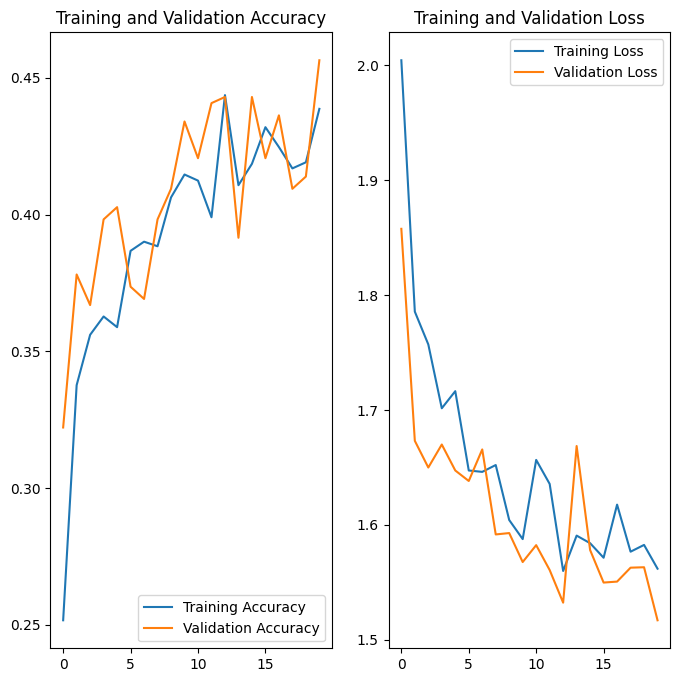

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
 Below are some findings

 * There is no much improvement in the accuracy but defnetly we can say that with help of Augmentation can fix the overfitting

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
path=[]
label=[]
for c in class_names:
    for p in data_dir_train.glob(c+'/*.jpg'):
        path.append(str(p))
        label.append(c)
df_dict_original=dict(zip(path,label))
df_original=pd.DataFrame(list(df_dict_original.items()),columns=['Path','Label'])
df_original

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


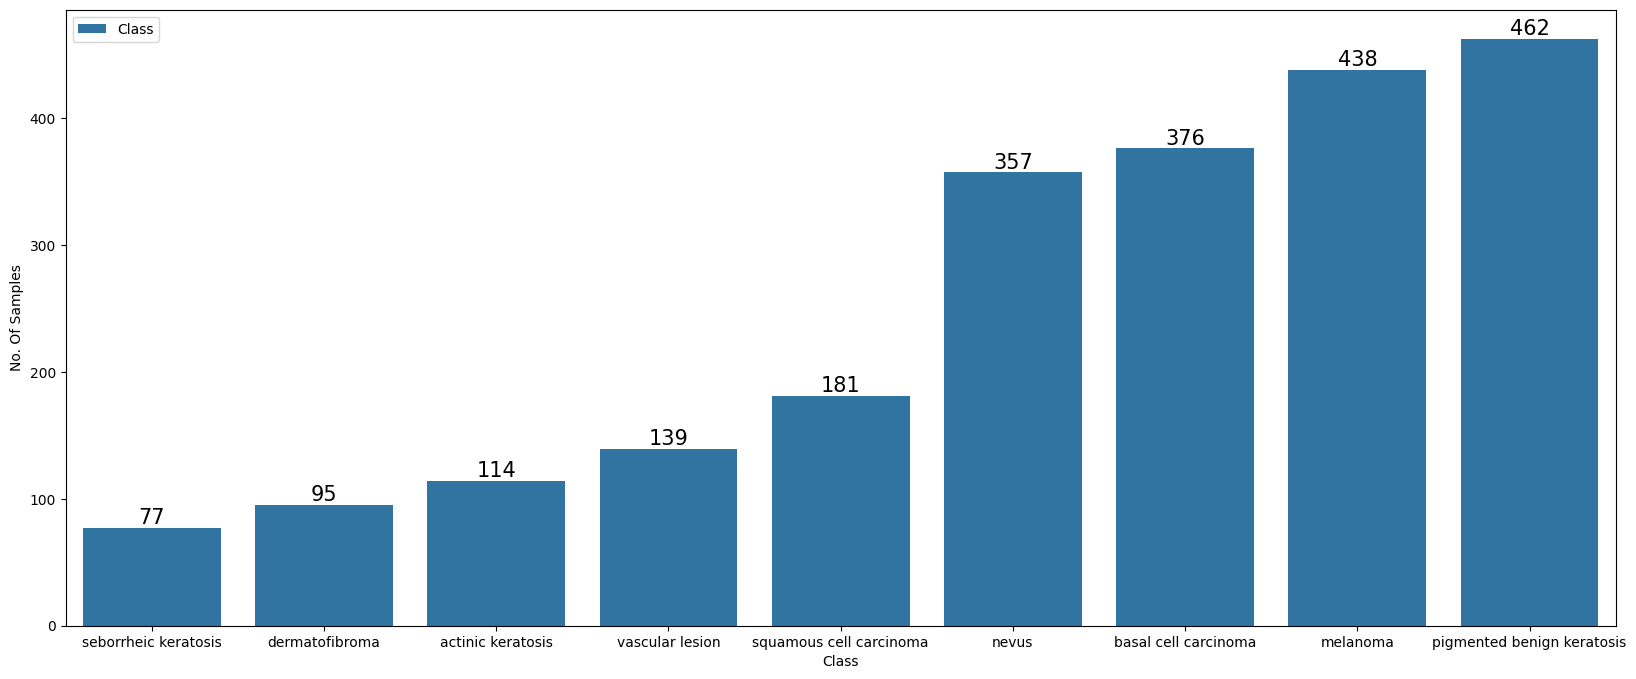

In [29]:
cnt=[]
for i in class_names:
    cnt.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
table2=pd.DataFrame(list(zip(class_names,cnt)),columns=['Class','No. Of Samples']).sort_values(by='No. Of Samples')

plt.figure(figsize=(20,8))
ax=sns.barplot(data=table2,y='No. Of Samples',x='Class',label='Class')
ax.bar_label(ax.containers[0],fontsize=15);

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
####     **Ans:-** seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
#### **Ans:-** Melanoma & pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD1F45AB910>: 100%|██████████| 500/500 [00:18<00:00, 27.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD1F4403C10>: 100%|██████████| 500/500 [00:20<00:00, 24.39 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD1F46FBD00>: 100%|██████████| 500/500 [00:19<00:00, 26.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7AD2740F9480>: 100%|██████████| 500/500 [01:19<00:00,  6.25 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AD274221450>: 100%|██████████| 500/500 [01:18<00:00,  6.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD1F4435360>: 100%|██████████| 500/500 [00:15<00:00, 31.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AD1F4761CF0>: 100%|██████████| 500/500 [00:35<00:00, 13.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD1F474AFE0>: 100%|██████████| 500/500 [00:14<00:00, 33.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AD1F4785CC0>: 100%|██████████| 500/500 [00:14<00:00, 33.60 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
!pip install glob2
import glob2

In [34]:
path_list_new = [x for x in glob2.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010750.jpg_6d6cc7db-8274-4662-b8a7-7ffb71f71912.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010799.jpg_54220264-2900-4a47-acec-b8649d5520ff.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011130.jpg_fc1eedb7-fc5f-4436-9179-18e77ec61b7f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009989.jpg_cd7bfefe-d752-4dca-bc16-9d69e2dddc74.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009886.jpg_bb463344-349f-48fc-8f18-18eb3e1e4489.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010990.jpg_318c3

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob2.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [36]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
final_df = pd.concat([df_original, df2], ignore_index=True)

In [38]:
final_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds_Aug = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,#label_mode='categorical',
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               validation_split=0.2,subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds_Aug = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,#label_mode='categorical',
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               validation_split=0.2,subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
## your code goes here

from keras.regularizers import l2
num_classes=9

model_1=Sequential()

# Rescalling
model_1.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

#1st Layer
model_1.add(layers.Conv2D(32, (3,3), padding='same',activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))
model_1.add(layers.Dropout(0.20))

#2nd Layer
model_1.add(layers.Conv2D(64, (3,3), padding='same',activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))
model_1.add(layers.Dropout(0.20))

#3rd Layer
model_1.add(layers.Conv2D(128, (3,3), padding='same',activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))
model_1.add(layers.Dropout(0.20))

#4rd Layer
model_1.add(layers.Conv2D(256, (3,3), padding='same',activation='relu'))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))
model_1.add(layers.Dropout(0.20))

#Flattren
model_1.add(layers.Flatten())
model_1.add(layers.Dense(256,activation='relu',kernel_regularizer=l2(0.001)))
model_1.add(layers.Dropout(0.25))

#FC Layer
model_1.add(layers.Dense(num_classes,activation='softmax'))
model_1.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
              #loss=tf.keras.losses.categorical_crossentropy(from_logits=True),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [44]:
epochs = 30
## Your code goes here, use 50 epochs.
history =model_1.fit(train_ds_Aug,
                   validation_data=val_ds_Aug,
                   epochs=epochs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 45s 248ms/step - loss: 2.3818 - accuracy: 0.1677 - val_loss: 1.9806 - val_accuracy: 0.2717
Epoch 2/30
169/169 [==============================] - 28s 162ms/step - loss: 1.8469 - accuracy: 0.2873 - val_loss: 1.8323 - val_accuracy: 0.2992
Epoch 3/30
169/169 [==============================] - 29s 166ms/step - loss: 1.7020 - accuracy: 0.3527 - val_loss: 1.5763 - val_accuracy: 0.4202
Epoch 4/30
169/169 [==============================] - 29s 162ms/step - loss: 1.5868 - accuracy: 0.3950 - val_loss: 1.5271 - val_accuracy: 0.4343
Epoch 5/30
169/169 [==============================] - 28s 160ms/step - loss: 1.5092 - accuracy: 0.4266 - val_loss: 1.5197 - val_accuracy: 0.4581
Epoch 6/30
169/169 [==============================] - 28s 162ms/step - loss: 1.4529 - accuracy: 0.4529 - val_loss: 1.5431 - val_accuracy: 0.4640
Epoch 7/30
169/169 [==============================] - 30s 174ms/step - loss: 1.3729 - accuracy: 0.4848 - val_loss: 1.3695 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

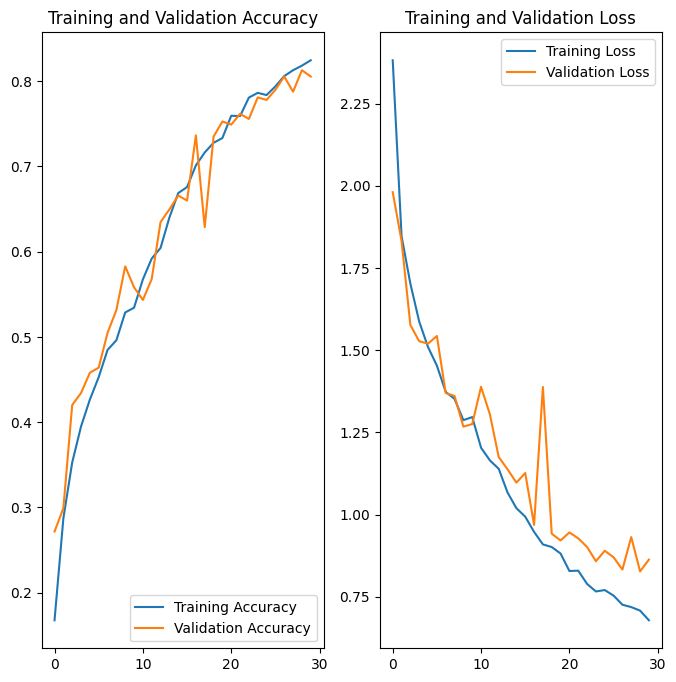

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* As we can that Over fitting can be handled by class imbalances
By adding the drop out & additinal layers we can achive the 84.4 % accuracy

* By adding still more layers & still fine tune the hyper parameter we may increase the accuracy




In [46]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,seed=123,#label_mode='categorical',
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               validation_split=0.2,subset='training')

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [47]:
history =model_1.fit(test_ds,
                   epochs=epochs)

Epoch 1/30
3/3 [==============================] - 4s 633ms/step - loss: 4.2528 - accuracy: 0.3684
Epoch 2/30
3/3 [==============================] - 4s 78ms/step - loss: 2.0347 - accuracy: 0.5158
Epoch 3/30
3/3 [==============================] - 3s 81ms/step - loss: 1.7507 - accuracy: 0.4526
Epoch 4/30
3/3 [==============================] - 4s 80ms/step - loss: 1.6211 - accuracy: 0.4842
Epoch 5/30
3/3 [==============================] - 3s 77ms/step - loss: 1.3831 - accuracy: 0.5579
Epoch 6/30
3/3 [==============================] - 4s 76ms/step - loss: 1.3098 - accuracy: 0.5789
Epoch 7/30
3/3 [==============================] - 3s 79ms/step - loss: 1.1434 - accuracy: 0.7474
Epoch 8/30
3/3 [==============================] - 3s 77ms/step - loss: 0.8966 - accuracy: 0.7474
Epoch 9/30
3/3 [==============================] - 3s 72ms/step - loss: 0.7726 - accuracy: 0.8211
Epoch 10/30
3/3 [==============================] - 3s 76ms/step - loss: 0.7203 - accuracy: 0.8316
Epoch 11/30
3/3 [===========

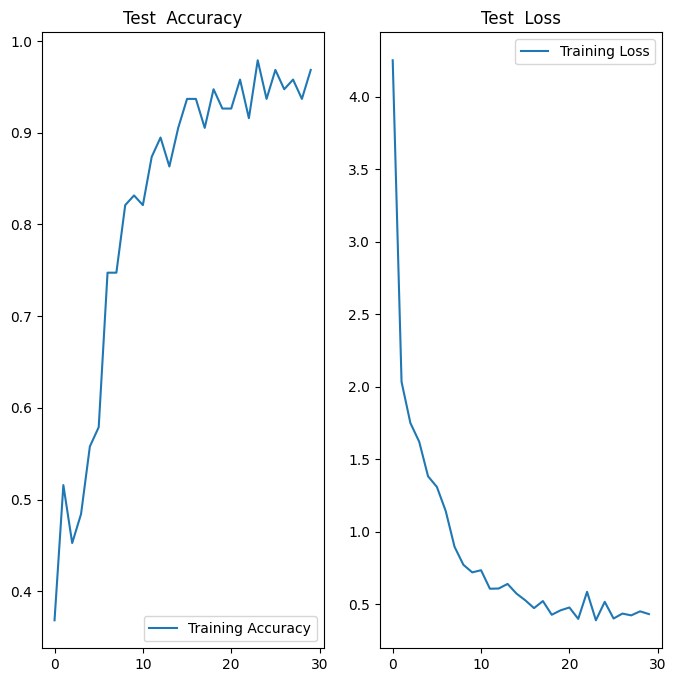

In [48]:
acc = history.history['accuracy']


loss = history.history['loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')

plt.legend(loc='lower right')
plt.title('Test  Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')

plt.legend(loc='upper right')
plt.title('Test  Loss')
plt.show()